## Libraries Imports

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose , STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error , mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing , SimpleExpSmoothing , Holt
from prophet import Prophet
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

## Data loading and exploration

In [2]:
train = pd.read_csv('train.csv' , parse_dates=['Date'])
test = pd.read_csv('test.csv' , parse_dates=['Date'])
store = pd.read_csv('store.csv')

C:\Users\PCCV\AppData\Local\Temp\ipykernel_22812\1842859682.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('train.csv' , parse_dates=['Date'])


## Data Columns Understanding

- **Store**: a unique Id for each store
- **Sales**: the turnover for any given day (target variable)
- **Customers**: the number of customers on a given day
- **Open**: an indicator for whether the store was open (0 = closed, 1 = open)
- **StateHoliday**: indicates a state holiday (a = public holiday, b = Easter holiday, c = Christmas, 0 = None)
- **SchoolHoliday**: indicates if the store was affected by the closure of public schools
- **StoreType**: differentiates between 4 different store models: a, b, c, d
- **Assortment**: describes an assortment level: a = basic, b = extra, c = extended
- **CompetitionDistance**: distance in meters to the nearest competitor store
- **CompetitionOpenSince[Month/Year]**: gives the approximate year and month of the time the nearest competitor was opened
- **Promo**: indicates whether a store is running a promo on that day
- **Promo2**: a continuing and consecutive promotion for some stores (0 = store is not participating, 1 = store is participating)
- **Promo2Since[Year/Week]**: describes the year and calendar week when the store started participating in Promo2
- **PromoInterval**: describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew

In [3]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Store shape:", store.shape)

Train shape: (1017209, 9)
Test shape: (41088, 8)
Store shape: (1115, 10)


In [4]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [5]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [6]:
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


## EDA

In [7]:
train = train.merge(store, on='Store', how='left')
test = test.merge(store, on='Store', how='left')

In [8]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [9]:
train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  object        
 8   SchoolHoliday              1017209 non-null  int64         
 9   StoreType                  1017209 non-null  object        
 10  Assortment                 1017209 non-null  object        
 11  CompetitionDistance        1014567 no

In [10]:
train.isnull().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64

In [11]:
test.isnull().sum()

Id                               0
Store                            0
DayOfWeek                        0
Date                             0
Open                            11
Promo                            0
StateHoliday                     0
SchoolHoliday                    0
StoreType                        0
Assortment                       0
CompetitionDistance             96
CompetitionOpenSinceMonth    15216
CompetitionOpenSinceYear     15216
Promo2                           0
Promo2SinceWeek              17232
Promo2SinceYear              17232
PromoInterval                17232
dtype: int64

In [12]:
# Check for duplicate (Store, Date) pairs
duplicate_dates = train.duplicated(subset=['Store', 'Date']).sum()
print(f"Duplicate (Store, Date) entries: {duplicate_dates}")

Duplicate (Store, Date) entries: 0


In [13]:
# Check the date range
print("Earliest date:", train['Date'].min())
print("Latest date:", train['Date'].max())

Earliest date: 2013-01-01 00:00:00
Latest date: 2015-07-31 00:00:00


In [ ]:
missing_dates = pd.date_range(start=train['Date'].min(), end=train['Date'].max()).difference(train['Date'].unique())
print("Missing calendar dates (global):", missing_dates)

Missing calendar dates (global): DatetimeIndex([], dtype='datetime64[ns]', freq='D')


In [ ]:
store_date_counts = train.groupby("Store")["Date"].nunique()
print(store_date_counts.describe())

count    1115.000000
mean      912.295067
std        67.729422
min       758.000000
25%       942.000000
50%       942.000000
75%       942.000000
max       942.000000
Name: Date, dtype: float64


In [16]:
def clean_and_impute(df):
    # Fill missing CompetitionDistance with median (assume no competitor nearby)
    df['CompetitionDistance'].fillna(df['CompetitionDistance'].median(), inplace=True)

    # Fill missing CompetitionOpenSinceMonth/Year with the date's month/year (assume competition not started yet)
    df['CompetitionOpenSinceMonth'].fillna(df['Date'].dt.month, inplace=True)
    df['CompetitionOpenSinceYear'].fillna(df['Date'].dt.year, inplace=True)

    # Fill missing Promo2SinceWeek/Year with 0 (assume no ongoing promo2)
    df['Promo2SinceWeek'].fillna(0, inplace=True)
    df['Promo2SinceYear'].fillna(0, inplace=True)

    # Fill missing PromoInterval with "None" (no promo interval)
    df['PromoInterval'].fillna("None", inplace=True)
    return df


train = clean_and_impute(train)
test = clean_and_impute(test)

C:\Users\PCCV\AppData\Local\Temp\ipykernel_22812\3346479415.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['CompetitionDistance'].fillna(df['CompetitionDistance'].median(), inplace=True)
C:\Users\PCCV\AppData\Local\Temp\ipykernel_22812\3346479415.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al

In [17]:
train.isnull().sum()

Store                        0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [18]:
test.isnull().sum()

Id                            0
Store                         0
DayOfWeek                     0
Date                          0
Open                         11
Promo                         0
StateHoliday                  0
SchoolHoliday                 0
StoreType                     0
Assortment                    0
CompetitionDistance           0
CompetitionOpenSinceMonth     0
CompetitionOpenSinceYear      0
Promo2                        0
Promo2SinceWeek               0
Promo2SinceYear               0
PromoInterval                 0
dtype: int64

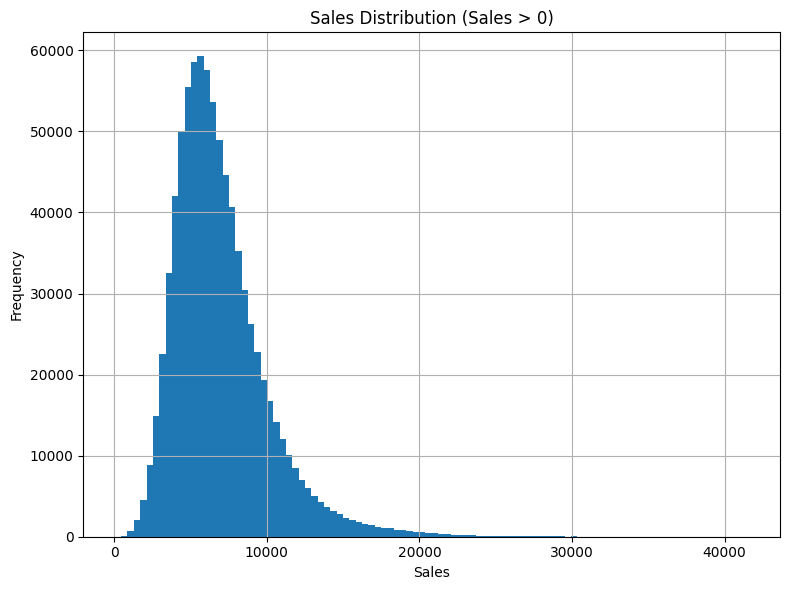

In [19]:
plt.figure(figsize=(8, 6))
train[train['Sales'] > 0]['Sales'].hist(bins=100)
plt.title('Sales Distribution (Sales > 0)')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

C:\Users\PCCV\AppData\Local\Temp\ipykernel_22812\290431458.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = daily_sales.resample('M').sum()


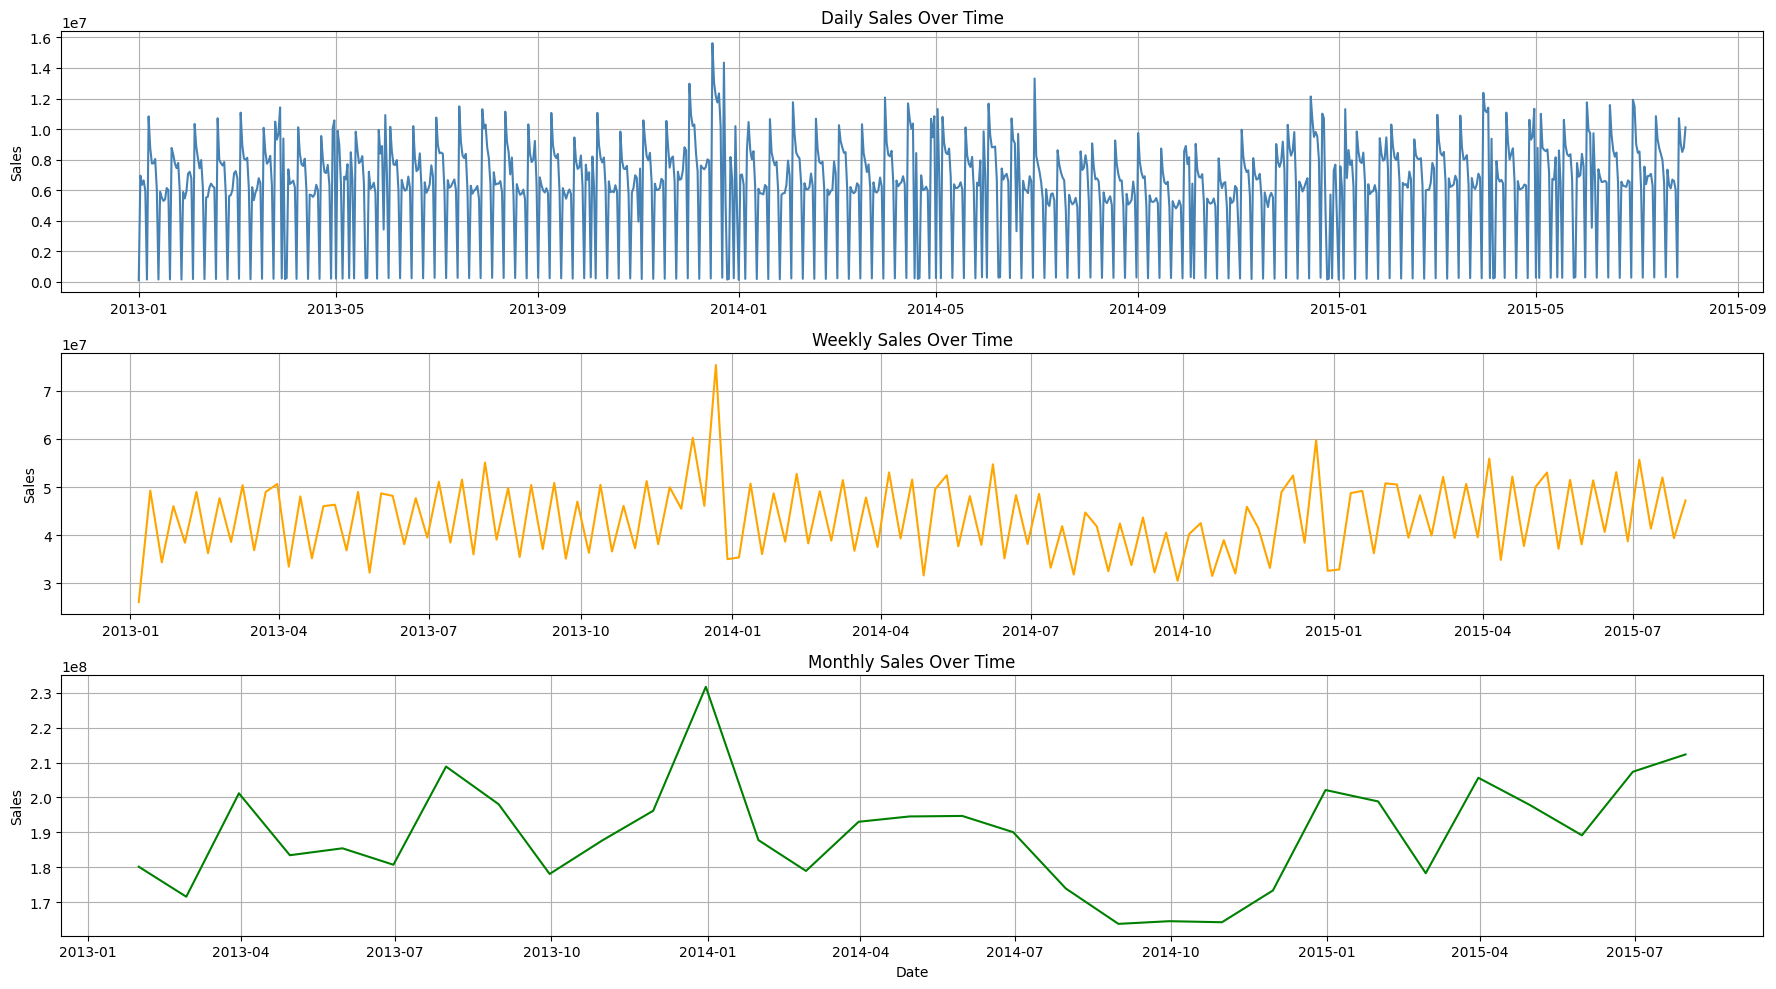

In [20]:
# Resample sales data
daily_sales = train.groupby('Date')['Sales'].sum().reset_index().set_index('Date')
weekly_sales = daily_sales.resample('W').sum()
monthly_sales = daily_sales.resample('M').sum()


plt.figure(figsize=(18, 10))

# Daily Sales
plt.subplot(3, 1, 1)
plt.plot(daily_sales, label='Daily Sales', color='steelblue')
plt.title('Daily Sales Over Time')
plt.ylabel('Sales')
plt.grid(True)

# Weekly Sales
plt.subplot(3, 1, 2)
plt.plot(weekly_sales, label='Weekly Sales', color='orange')
plt.title('Weekly Sales Over Time')
plt.ylabel('Sales')
plt.grid(True)

# Monthly Sales
plt.subplot(3, 1, 3)
plt.plot(monthly_sales, label='Monthly Sales', color='green')
plt.title('Monthly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)

plt.tight_layout()
plt.show()


In [21]:
daily_sales['Year'] = daily_sales.index.year
daily_sales['Month'] = daily_sales.index.month
daily_sales['Day'] = daily_sales.index.day
daily_sales['DayOfWeek'] = daily_sales.index.dayofweek
daily_sales['WeekOfYear'] = daily_sales.index.isocalendar().week

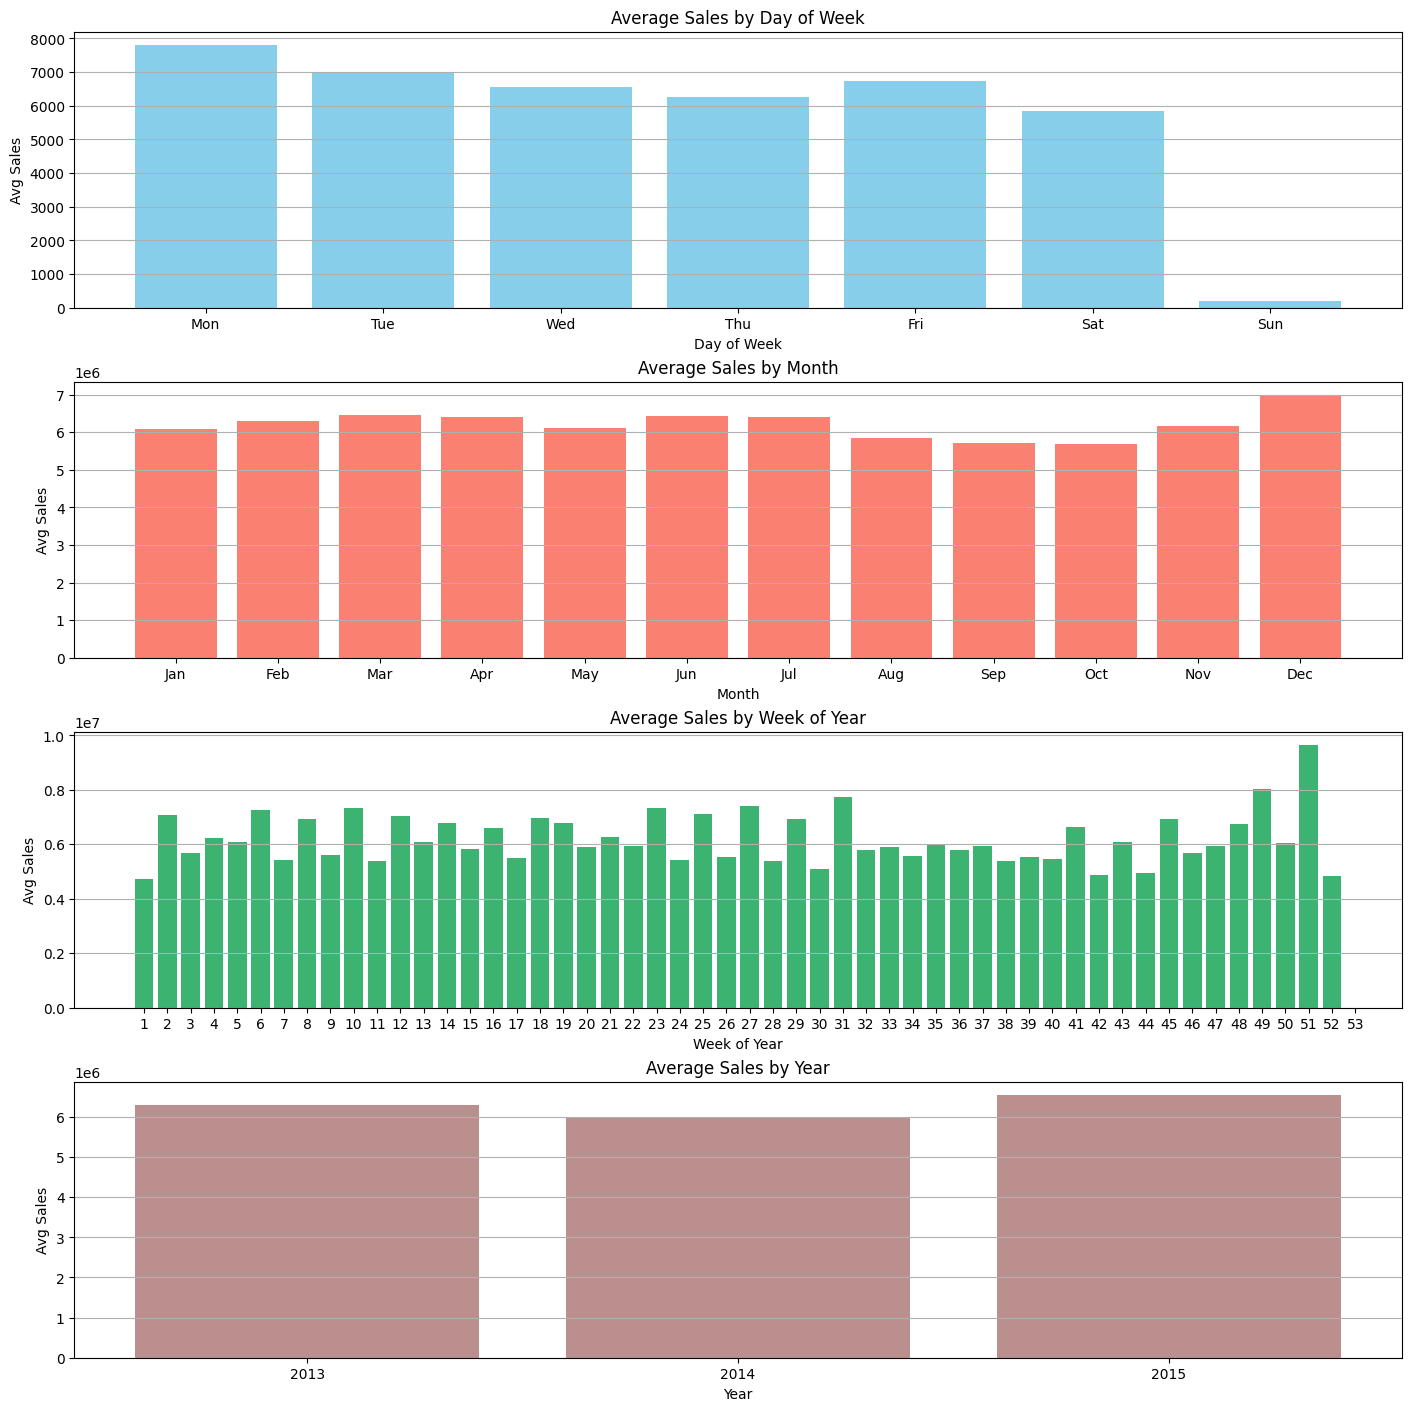

In [22]:
dow_avg = train.groupby("DayOfWeek")["Sales"].mean()
monthly_avg = daily_sales.groupby("Month")["Sales"].mean()
woy_avg = daily_sales.groupby("WeekOfYear")["Sales"].mean()
year_avg = daily_sales.groupby("Year")["Sales"].mean()


fig, axs = plt.subplots(4, 1, figsize=(14, 14), constrained_layout=True)

# Day of Week
axs[0].bar(dow_avg.index, dow_avg.values, color='skyblue')
axs[0].set_title("Average Sales by Day of Week")
axs[0].set_xlabel("Day of Week")
axs[0].set_ylabel("Avg Sales")
axs[0].set_xticks(range(1, 8))
axs[0].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
axs[0].grid(axis='y')

# Month
axs[1].bar(monthly_avg.index, monthly_avg.values, color='salmon')
axs[1].set_title("Average Sales by Month")
axs[1].set_xlabel("Month")
axs[1].set_ylabel("Avg Sales")
axs[1].set_xticks(range(1, 13))
axs[1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axs[1].grid(axis='y')

# Week of Year
axs[2].bar(woy_avg.index, woy_avg.values, color='mediumseagreen')
axs[2].set_title("Average Sales by Week of Year")
axs[2].set_xlabel("Week of Year")
axs[2].set_xticks(range(1, 54)) 
axs[2].set_ylabel("Avg Sales")
axs[2].grid(axis='y')


# Year
axs[3].bar(year_avg.index, year_avg.values, color='rosybrown')
axs[3].set_title("Average Sales by Year")
axs[3].set_xlabel("Year")
axs[3].set_ylabel("Avg Sales")
axs[3].grid(axis='y')
axs[3].set_xticks(year_avg.index)
axs[3].set_xticklabels(year_avg.index)



plt.show()

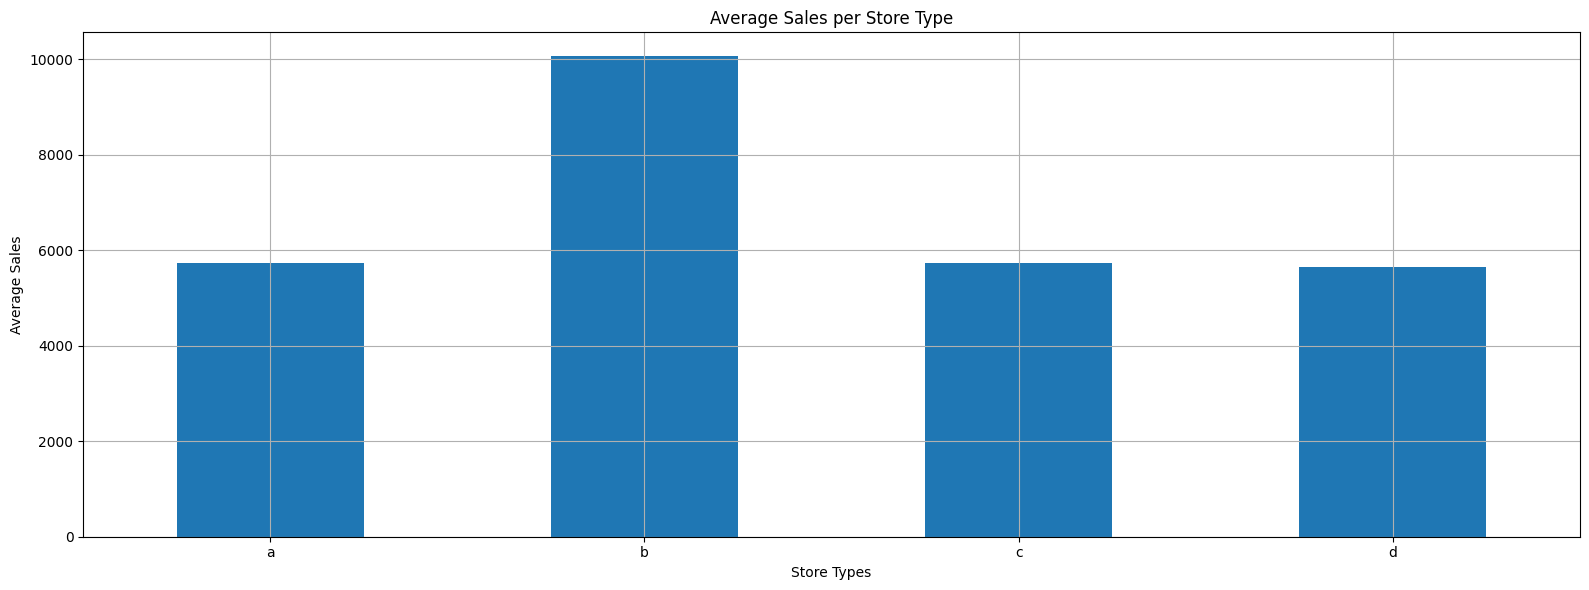

In [23]:
avg_sales = train.groupby('StoreType')['Sales'].mean()
plt.figure(figsize=(16, 6))
avg_sales.plot(kind='bar')
plt.title("Average Sales per Store Type")
plt.ylabel("Average Sales")
plt.xlabel("Store Types")
plt.grid(True)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


C:\Users\PCCV\AppData\Local\Temp\ipykernel_22812\2655149460.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(['No Promo', 'Promo'])
C:\Users\PCCV\AppData\Local\Temp\ipykernel_22812\2655149460.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(['No Holiday', 'Holiday'])


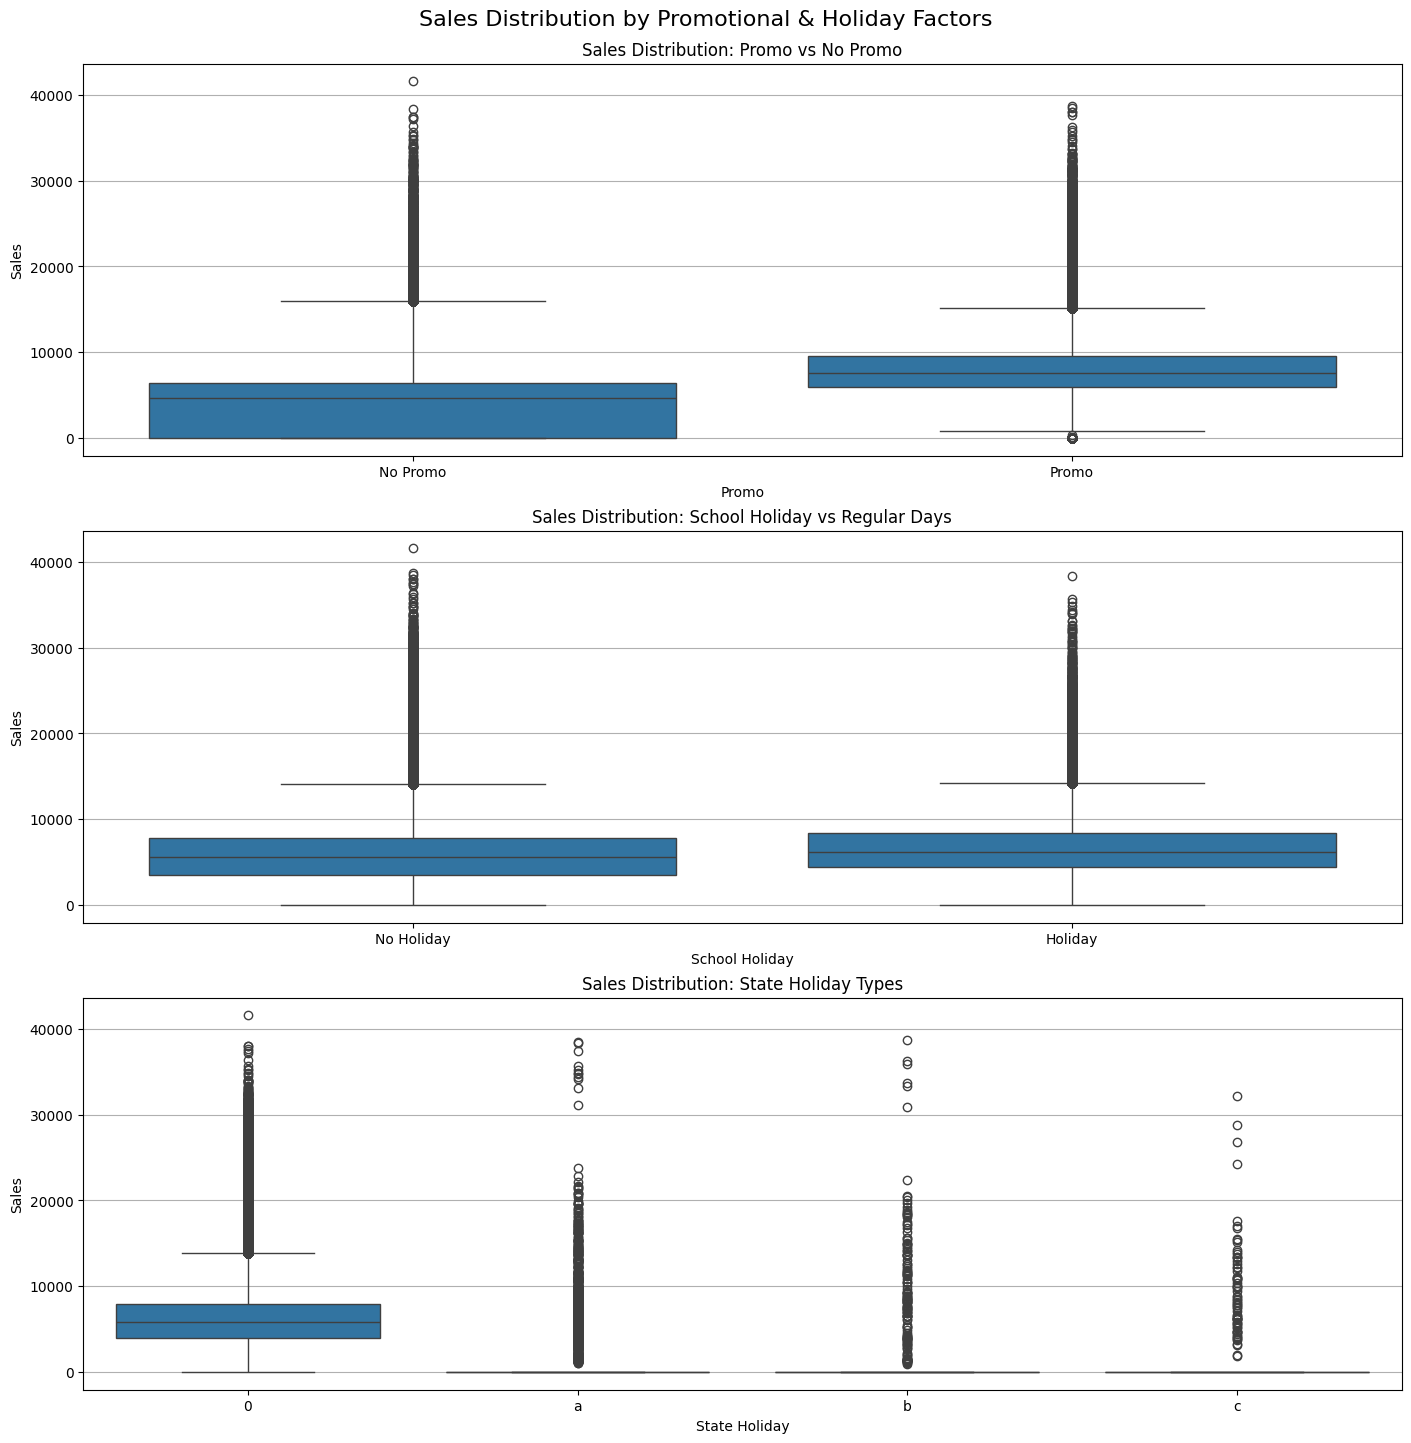

In [24]:
fig, axs = plt.subplots(3, 1, figsize=(14, 14), constrained_layout=True)

# 1. Promo vs No Promo
sns.boxplot(x='Promo', y='Sales', data=train, ax=axs[0])
axs[0].set_title("Sales Distribution: Promo vs No Promo")
axs[0].set_xlabel("Promo")
axs[0].set_ylabel("Sales")
axs[0].set_xticklabels(['No Promo', 'Promo'])
axs[0].grid(True, axis='y')

# 2. School Holiday vs Regular Days
sns.boxplot(x='SchoolHoliday', y='Sales', data=train, ax=axs[1])
axs[1].set_title("Sales Distribution: School Holiday vs Regular Days")
axs[1].set_xlabel("School Holiday")
axs[1].set_ylabel("Sales")
axs[1].set_xticklabels(['No Holiday', 'Holiday'])
axs[1].grid(True, axis='y')

# 3. State Holiday Types
sns.boxplot(x='StateHoliday', y='Sales', data=train, ax=axs[2])
axs[2].set_title("Sales Distribution: State Holiday Types")
axs[2].set_xlabel("State Holiday")
axs[2].set_ylabel("Sales")
axs[2].grid(True, axis='y')


plt.suptitle("Sales Distribution by Promotional & Holiday Factors", fontsize=16, y=1.02)
plt.show()


## Time Series Decomposition
##### --> To extract trend , seasonality , residuals 

### Seasonal decompose

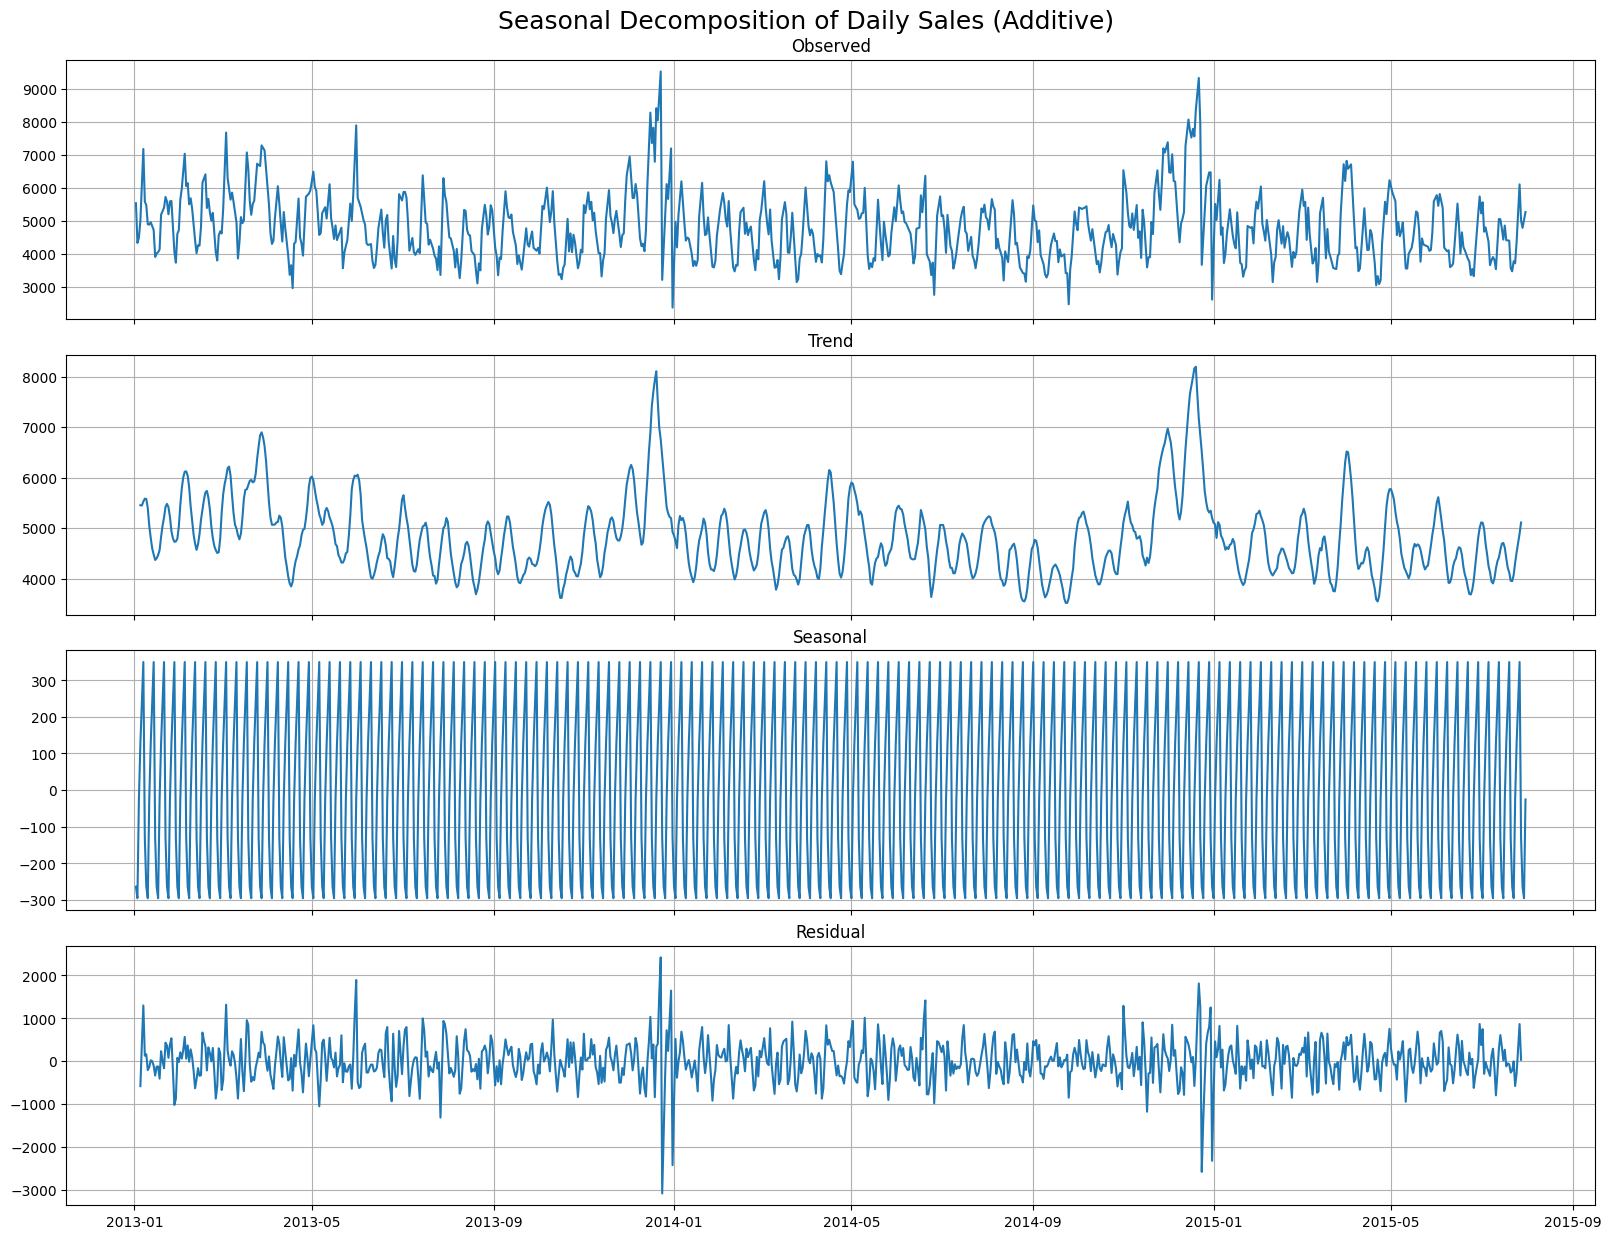

In [ ]:
store_id = 1
store_sales = train[(train['Store'] == 1) & (train['Open'] == 1)].copy()
daily_sales = store_sales[store_sales["Sales"] > 0] 
daily_sales = daily_sales.groupby('Date')['Sales'].sum().reset_index()
daily_sales.set_index("Date", inplace=True)
daily_sales = daily_sales.asfreq('D')  
daily_sales.interpolate(method='time', inplace=True)


result = seasonal_decompose(daily_sales, model='additive', period=7)  
observed = result.observed
trend = result.trend
seasonality = result.seasonal
residual = result.resid


fig, axs = plt.subplots(4, 1, figsize=(16, 12), sharex=True, constrained_layout=True)

axs[0].plot(observed, label='Observed')
axs[0].set_title('Observed')
axs[0].grid(True)

axs[1].plot(trend, label='Trend')
axs[1].set_title('Trend')
axs[1].grid(True)

axs[2].plot(seasonality, label='Seasonal')
axs[2].set_title('Seasonal')
axs[2].grid(True)

axs[3].plot(residual, label='Residual')
axs[3].set_title('Residual')
axs[3].grid(True)

fig.suptitle("Seasonal Decomposition of Daily Sales (Additive)", fontsize=18, y=1.02)
plt.show()

In [26]:
daily_sales

,Sales
Date,
2013-01-02,5530.0
2013-01-03,4327.0
2013-01-04,4486.0
2013-01-05,4997.0
2013-01-06,6086.5
...,...
2015-07-27,6102.0
2015-07-28,5011.0
2015-07-29,4782.0


### STL decomposition with weekly seasonality

C:\Users\PCCV\AppData\Local\Temp\ipykernel_22812\746788434.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


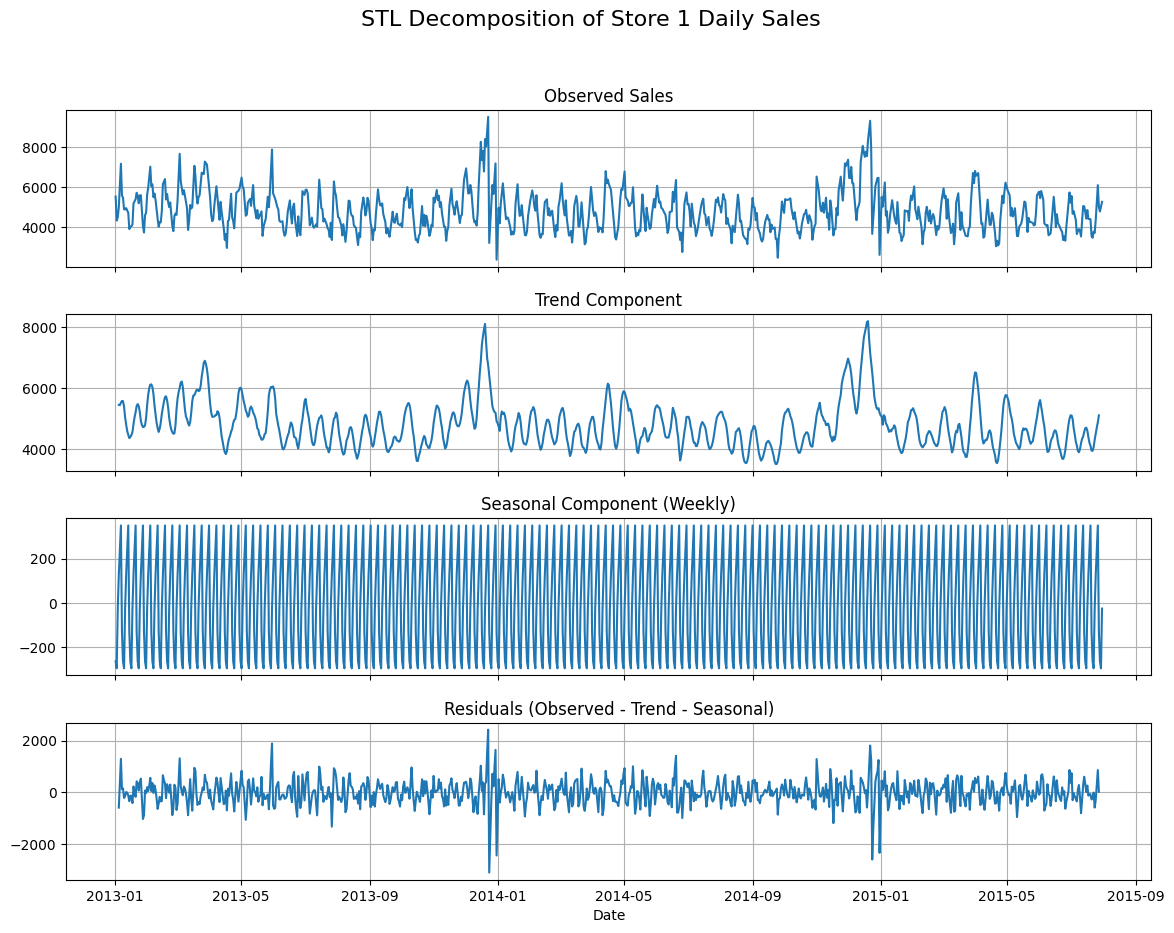

In [ ]:
stl = STL(daily_sales, period=7)
stl_result = stl.fit()
observed1 = result.observed
trend1 = result.trend
seasonal1 = result.seasonal
resid1 = result.resid


fig, axs = plt.subplots(4, 1, figsize=(14, 10), sharex=True, gridspec_kw={'hspace': 0.3})

axs[0].plot(observed1, label='Observed')
axs[0].set_title('Observed Sales')
axs[0].grid(True)

axs[1].plot(trend1, label='Trend')
axs[1].set_title('Trend Component')
axs[1].grid(True)

axs[2].plot(seasonal1, label='Seasonality')
axs[2].set_title('Seasonal Component (Weekly)')
axs[2].grid(True)

axs[3].plot(resid1, label='Residuals')
axs[3].set_title('Residuals (Observed - Trend - Seasonal)')
axs[3].grid(True)


fig.suptitle(f'STL Decomposition of Store 1 Daily Sales', fontsize=16)
plt.xlabel("Date")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Plot ACF and PACF

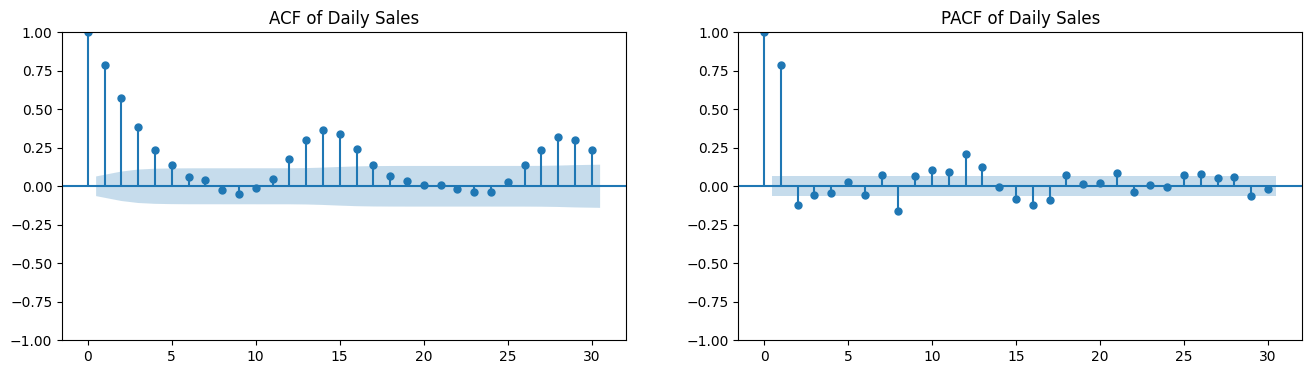

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

plot_acf(daily_sales.dropna(), lags=30, ax=axes[0])
axes[0].set_title("ACF of Daily Sales")

plot_pacf(daily_sales.dropna(), lags=30, ax=axes[1], method='ywm')
axes[1].set_title("PACF of Daily Sales")

plt.show()

# `Models`

In [29]:
def rmspe(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    y_true_nz = y_true[non_zero_indices]
    y_pred_nz = y_pred[non_zero_indices]
    
    percentage_error = np.abs((y_true_nz - y_pred_nz) / y_true_nz)
    return np.sqrt(np.mean(percentage_error ** 2))

def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    rmspe_val = rmspe(y_true, y_pred)
    
    print("-" * 40)
    print(f"{model_name} Results:")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"RMSPE: {rmspe_val:.4f}")
    print("-" * 40)
    
    return mse, rmse, mae, rmspe_val

In [ ]:
# Split train and test (# 90% train, 10% test)
split_index = int(len(daily_sales) * 0.9) 
train_data = daily_sales.iloc[:split_index]
test_data = daily_sales.iloc[split_index:]

y_true = test_data['Sales']

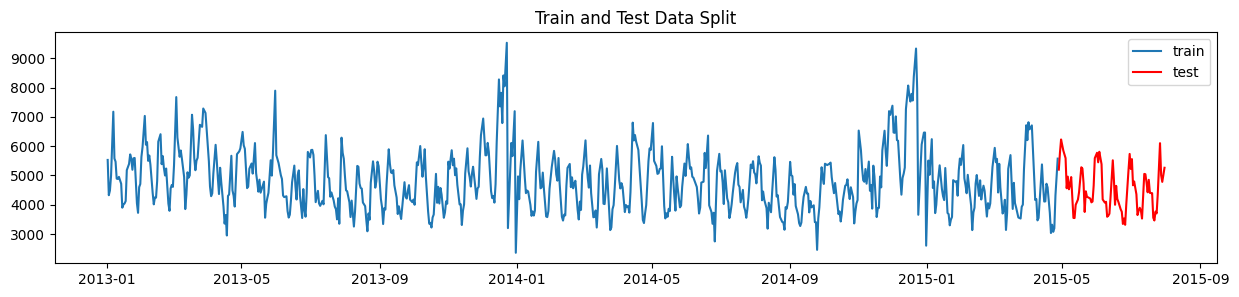

In [31]:
plt.figure(figsize=(15, 3))
plt.plot(train_data, label='train')
plt.plot(test_data, label='test' , color = 'red')
plt.legend()
plt.title("Train and Test Data Split")
plt.show()

In [32]:
test_data

,Sales
Date,
2015-04-28,5199.0
2015-04-29,5775.0
2015-04-30,6228.0
2015-05-01,6039.0
2015-05-02,5850.0
...,...
2015-07-27,6102.0
2015-07-28,5011.0
2015-07-29,4782.0


### 1- Simple Naive Models

----------------------------------------
Naive Forecast Results:
MSE: 599634.43
RMSE: 774.36
MAE: 647.56
RMSPE: 0.1705
----------------------------------------


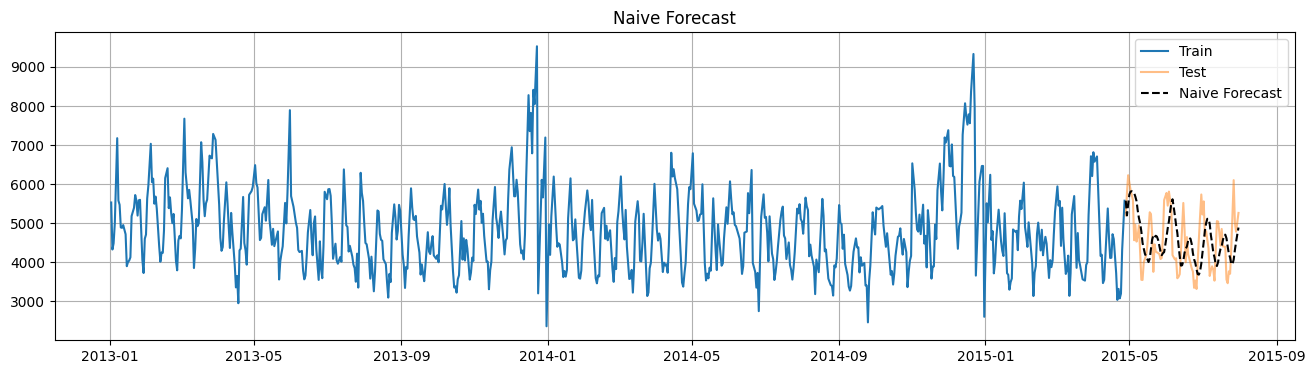

In [33]:
naive_pred = train_data[-1:].values[0][0]
naive_forecast = np.array([naive_pred] + [test_data['Sales'].iloc[max(0, i-7):i].mean() for i in range(1, len(test_data))])

naive_metrics = evaluate_model(y_true, naive_forecast, "Naive Forecast")


plt.figure(figsize=(16,4))
plt.plot(train_data.index, train_data, label='Train')
plt.plot(test_data.index, test_data, label='Test' , alpha=0.5)
plt.plot(test_data.index, naive_forecast, label='Naive Forecast', linestyle='--' , color='black')
plt.title("Naive Forecast")
plt.legend()
plt.grid(True)
plt.show()

----------------------------------------
Moving Average Forecast Results:
MSE: 615252.35
RMSE: 784.38
MAE: 657.02
RMSPE: 0.1722
----------------------------------------


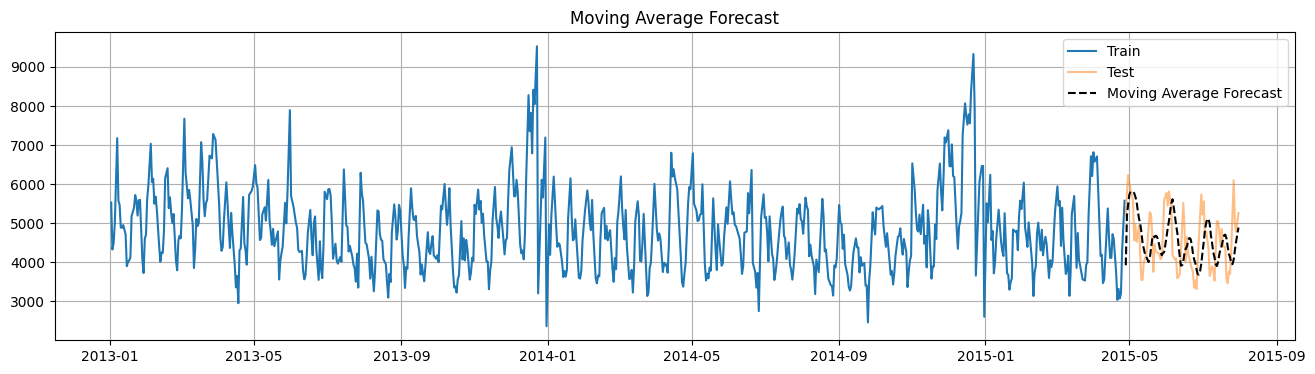

In [ ]:
moving_avg_pred = train_data['Sales'].rolling(window=7).mean().iloc[-1]  
moving_avg_forecast = np.array([moving_avg_pred] + [test_data['Sales'].iloc[max(0, i-7):i].mean() for i in range(1, len(test_data))])

moving_avg_metrics = evaluate_model(test_data['Sales'], moving_avg_forecast, "Moving Average Forecast")

plt.figure(figsize=(16,4))
plt.plot(train_data.index, train_data['Sales'], label='Train')
plt.plot(test_data.index, test_data['Sales'], label='Test' , alpha=0.5)
plt.plot(test_data.index, moving_avg_forecast, label='Moving Average Forecast', linestyle='--' , color='black')
plt.title("Moving Average Forecast")
plt.legend()
plt.grid(True)
plt.show()

### 2- ETS Models

We'll focus on these 3 types :
- Simple Exponential Smoothing (SES) - handles level only
- Holt's Linear Method (DES) - handles level and trend
- Holt-Winters Method (TES) - handles level, trend, and seasonality

#### `SES` Model : 

----------------------------------------
Simple Exponential Smoothing Results:
MSE: 1528683.46
RMSE: 1236.40
MAE: 1062.46
RMSPE: 0.3176
----------------------------------------


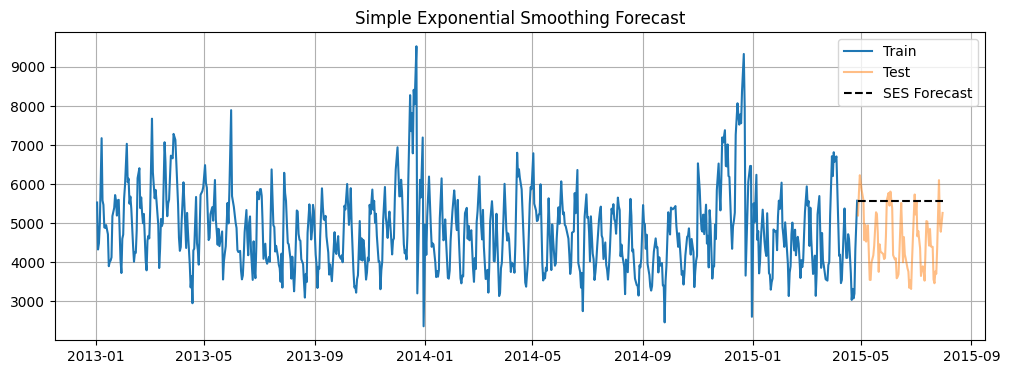

In [35]:
ses_model = SimpleExpSmoothing(train_data).fit(optimized=True)
ses_forecast = ses_model.forecast(steps=len(test_data))

ses_metrics = evaluate_model(test_data['Sales'], ses_forecast, "Simple Exponential Smoothing")
plt.figure(figsize=(12,4))
plt.plot(train_data.index, train_data['Sales'], label='Train')
plt.plot(test_data.index, test_data['Sales'], label='Test' , alpha=0.5)
plt.plot(test_data.index, ses_forecast, label='SES Forecast', linestyle='--' , color='black')
plt.title("Simple Exponential Smoothing Forecast")
plt.legend()
plt.grid(True)
plt.show()

#### `DES` Model : 

----------------------------------------
Holt's Linear Trend Model Results:
MSE: 16259286.83
RMSE: 4032.28
MAE: 3628.60
RMSPE: 0.9709
----------------------------------------


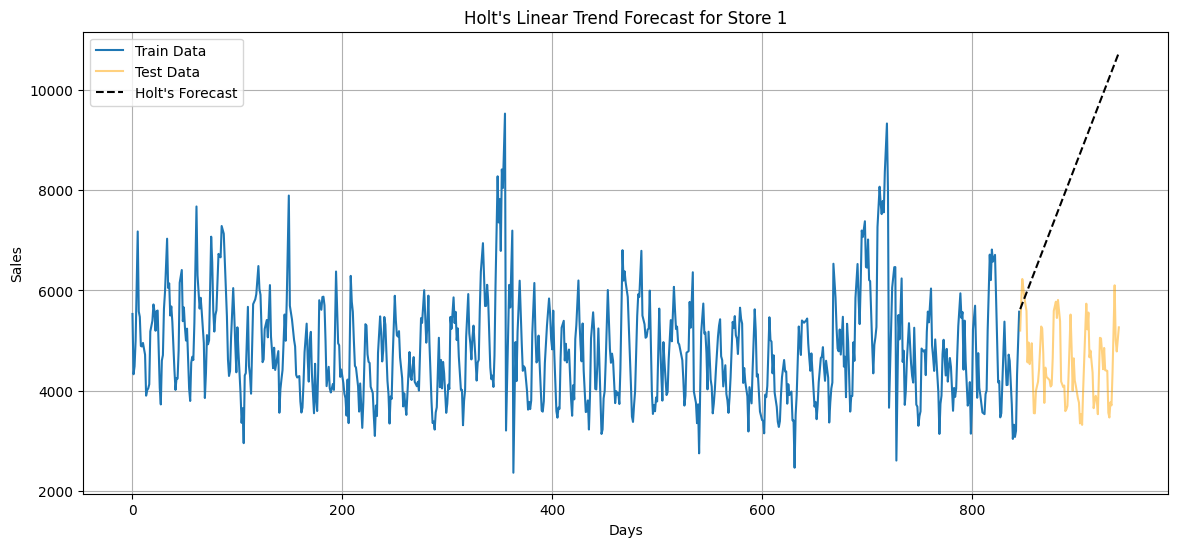

In [36]:
des_model = Holt(train_data['Sales']).fit()
des_forecast = des_model.forecast(len(test_data))

des_metrics = evaluate_model(test_data['Sales'], des_forecast, "Holt's Linear Trend Model")

plt.figure(figsize=(14,6))
plt.plot(range(len(train_data)), train_data['Sales'], label='Train Data')
plt.plot(range(len(train_data), len(train_data) + len(y_true)), y_true, label='Test Data', alpha = 0.5 ,color='orange')
plt.plot(range(len(train_data), len(train_data) + len(des_forecast)), des_forecast, label="Holt's Forecast", color='black', linestyle='--')
plt.title(f"Holt's Linear Trend Forecast for Store {store_id}")
plt.xlabel('Days')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

#### `TES` Model Add : 

----------------------------------------
Holt-Winters Additive Results:
MSE: 4618830.57
RMSE: 2149.15
MAE: 1910.58
RMSPE: 0.5297
----------------------------------------


c:\Users\PCCV\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


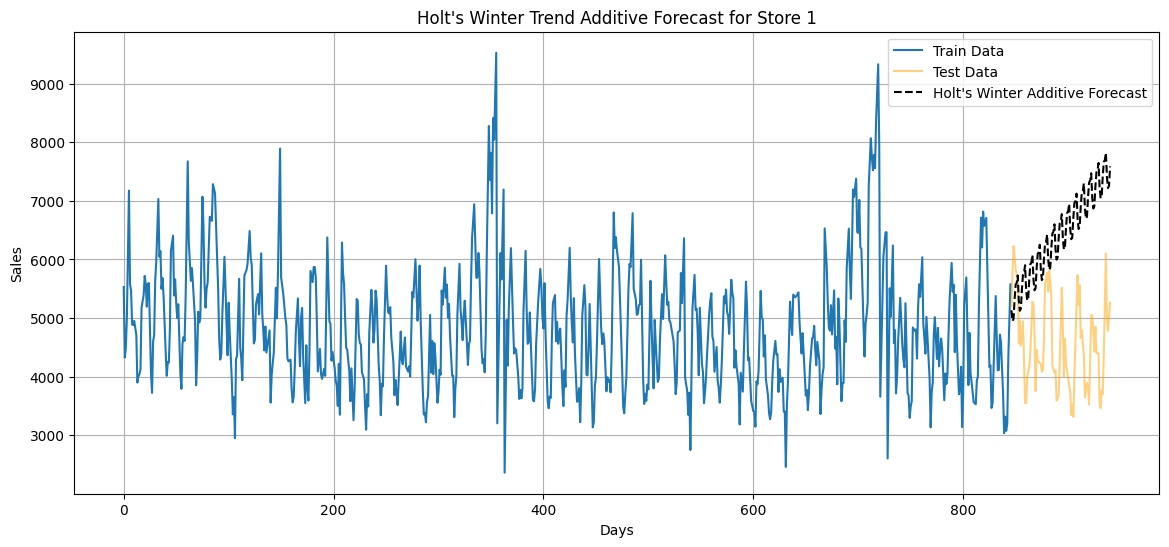

In [37]:
tes_model = ExponentialSmoothing(train_data['Sales'], trend='add', seasonal='add', seasonal_periods=7).fit()
tes_forecast = tes_model.forecast(len(test_data))
tes_metrics = evaluate_model(y_true, tes_forecast, "Holt-Winters Additive")

plt.figure(figsize=(14,6))
plt.plot(range(len(train_data)), train_data['Sales'], label='Train Data')
plt.plot(range(len(train_data), len(train_data) + len(y_true)), y_true, label='Test Data', alpha = 0.5 ,color='orange')
plt.plot(range(len(train_data), len(train_data) + len(tes_forecast)), tes_forecast, label="Holt's Winter Additive Forecast", color='black', linestyle='--')
plt.title(f"Holt's Winter Trend Additive Forecast for Store {store_id}")
plt.xlabel('Days')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

#### `TES` Model Mul : 

c:\Users\PCCV\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


----------------------------------------
Holt-Winters Multiplicative Results:
MSE: 5154134.89
RMSE: 2270.27
MAE: 2017.04
RMSPE: 0.5569
----------------------------------------


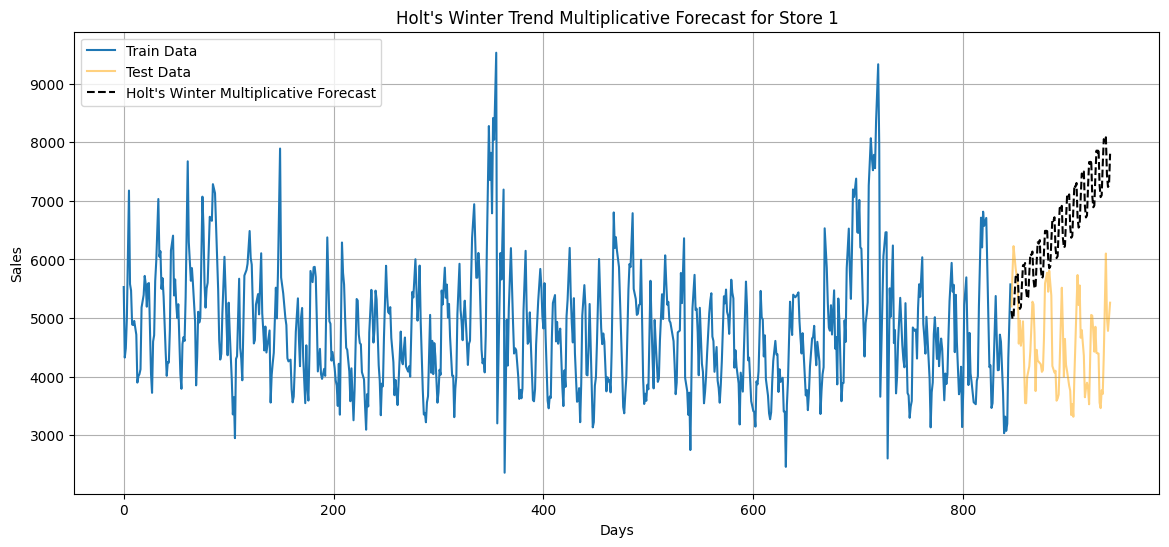

In [38]:
tes_model_mul = ExponentialSmoothing(train_data['Sales'], trend='add', seasonal='mul', seasonal_periods=7).fit()
tes_forecast_mul = tes_model_mul.forecast(len(test_data))
tes_metrics_mul = evaluate_model(y_true, tes_forecast_mul, "Holt-Winters Multiplicative")

plt.figure(figsize=(14,6))
plt.plot(range(len(train_data)), train_data['Sales'], label='Train Data')
plt.plot(range(len(train_data), len(train_data) + len(y_true)), y_true, label='Test Data', alpha = 0.5 ,color='orange')
plt.plot(range(len(train_data), len(train_data) + len(tes_forecast_mul)), tes_forecast_mul, label="Holt's Winter Multiplicative Forecast", color='black', linestyle='--')
plt.title(f"Holt's Winter Trend Multiplicative Forecast for Store {store_id}")
plt.xlabel('Days')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

### 3- ARIMA & SARIMAX

In [39]:
#check for stationary
result = adfuller(daily_sales)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print(f"Critical Values: {result[4]}")

ADF Statistic: -4.522023631164086
p-value: 0.00017938583104226927
Critical Values: {'1%': -3.4374778690219956, '5%': -2.864686684217556, '10%': -2.5684454926748583}


In [40]:
params = [(p, d, q) for p in range(0, 5) for d in range(0, 2) for q in range(0, 5)]
results = []
for p, d, q in params:
    model = ARIMA(daily_sales, order=(p, d, q))
    result = model.fit()
    results.append((p, d, q, result.aic))

results_df = pd.DataFrame(results, columns=['p', 'd', 'q', 'AIC'])
results_df = results_df.sort_values(by='AIC').reset_index(drop=True)
results_df

c:\Users\PCCV\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\PCCV\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\PCCV\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\PCCV\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Usin

,p,d,q,AIC
0,4,0,3,14730.153961
1,4,1,4,14732.332029
2,3,1,4,14736.729479
3,4,0,2,14745.372114
4,4,1,2,14745.620534
5,4,0,4,14747.200538
6,3,0,4,14747.517688
7,2,1,4,14747.764497
8,3,1,3,14752.141739
9,4,1,1,14754.195159


In [41]:
best_arima= ARIMA(daily_sales, order=(4,0,3))
best_result = best_arima.fit()
print(best_result.summary())

c:\Users\PCCV\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\PCCV\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  941
Model:                 ARIMA(4, 0, 3)   Log Likelihood               -7356.077
Date:                Fri, 30 May 2025   AIC                          14730.154
Time:                        19:05:53   BIC                          14773.776
Sample:                    01-02-2013   HQIC                         14746.782
                         - 07-31-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4815.5574    105.623     45.592      0.000    4608.540    5022.575
ar.L1          1.0599      0.052     20.421      0.000       0.958       1.162
ar.L2         -0.0300      0.099     -0.304      0.7

c:\Users\PCCV\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


----------------------------------------
ARIMA Forecast Results:
MSE: 582687.35
RMSE: 763.34
MAE: 653.14
RMSPE: 0.1896
----------------------------------------


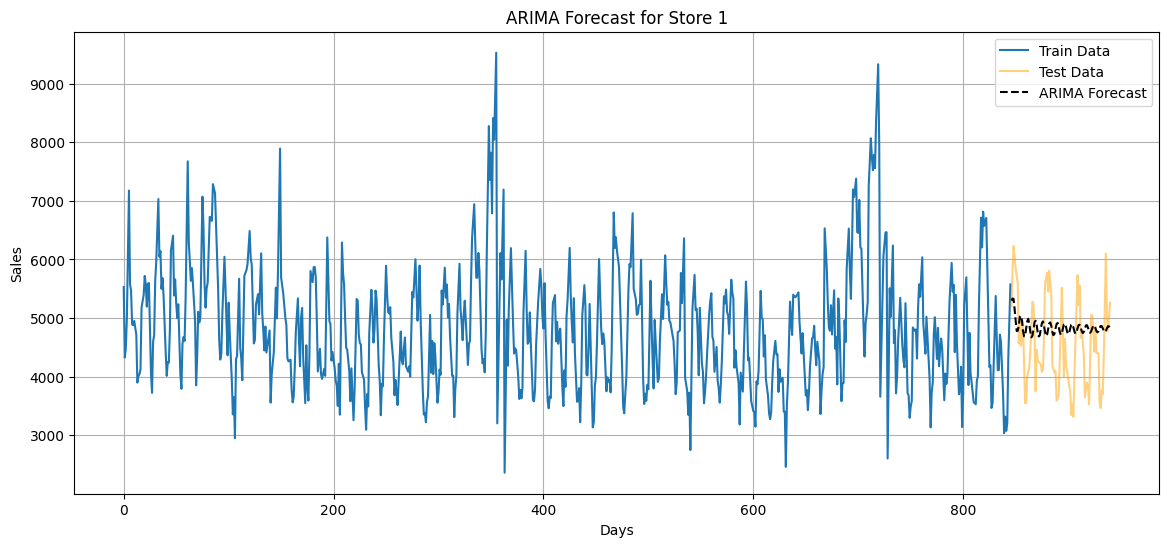

In [42]:
forecast_arima = best_result.forecast(steps=len(test_data))
arima_metrics = evaluate_model(y_true, forecast_arima, "ARIMA Forecast")

plt.figure(figsize=(14,6))
plt.plot(range(len(train_data)), train_data['Sales'], label='Train Data')
plt.plot(range(len(train_data), len(train_data) + len(y_true)), y_true, label='Test Data', alpha = 0.5 ,color='orange')
plt.plot(range(len(train_data), len(train_data) + len(forecast_arima)), forecast_arima, label="ARIMA Forecast", color='black', linestyle='--')
plt.title(f"ARIMA Forecast for Store {store_id}")
plt.xlabel('Days')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

In [43]:
sarimax_params = [(P, D, Q) for P in range(0, 3) for D in range(0, 2) for Q in range(0, 3)]
results_sarimax = []
for P, D, Q in sarimax_params:
    model = SARIMAX(daily_sales, order=(4, 0, 3), seasonal_order=(P, D, Q, 7))
    result = model.fit()
    results_sarimax.append((P, D, Q, result.aic))


results_sarimax_df = pd.DataFrame(results_sarimax, columns=['P', 'D', 'Q', 'AIC'])
results_sarimax_df = results_sarimax_df.sort_values(by='AIC').reset_index(drop=True)
results_sarimax_df

c:\Users\PCCV\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\PCCV\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\PCCV\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\PCCV\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as sta

,P,D,Q,AIC
0,1,1,1,14613.005784
1,0,1,2,14613.374567
2,2,1,2,14613.437140
3,0,1,1,14614.901350
4,2,1,1,14615.818580
5,1,1,2,14616.777428
6,1,0,1,14690.901973
7,2,0,2,14714.614574
8,2,1,0,14725.866579
9,1,0,2,14733.557492


In [44]:
best_sarimax = SARIMAX(daily_sales, order=(4, 0, 3), seasonal_order=(1, 1, 1, 7))
best_sarimax_result = best_sarimax.fit()
print(best_sarimax_result.summary())

c:\Users\PCCV\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                      SARIMAX Results                                      
Dep. Variable:                               Sales   No. Observations:                  941
Model:             SARIMAX(4, 0, 3)x(1, 1, [1], 7)   Log Likelihood               -7296.503
Date:                             Fri, 30 May 2025   AIC                          14613.006
Time:                                     19:06:49   BIC                          14661.401
Sample:                                 01-02-2013   HQIC                         14631.460
                                      - 07-31-2015                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9669      0.374      5.263      0.000       1.234       2.699
ar.L2         -0.7773      

c:\Users\PCCV\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


----------------------------------------
SARIMAX Forecast Results:
MSE: 1200228.79
RMSE: 1095.55
MAE: 904.47
RMSPE: 0.2661
----------------------------------------


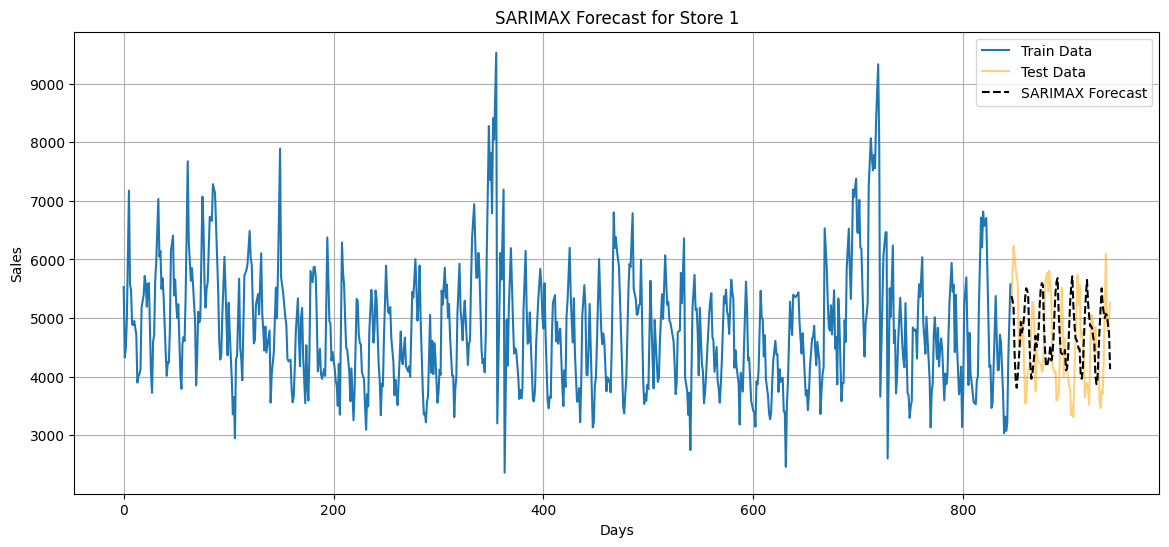

In [45]:
forecast_sarimax = best_sarimax_result.forecast(steps=len(test_data))
sarimax_metrics = evaluate_model(y_true, forecast_sarimax, "SARIMAX Forecast")

plt.figure(figsize=(14,6))
plt.plot(range(len(train_data)), train_data['Sales'], label='Train Data')
plt.plot(range(len(train_data), len(train_data) + len(y_true)), y_true, label='Test Data', alpha = 0.5 ,color='orange')
plt.plot(range(len(train_data), len(train_data) + len(forecast_sarimax)), forecast_sarimax, label="SARIMAX Forecast", color='black', linestyle='--')
plt.title(f"SARIMAX Forecast for Store {store_id}")
plt.xlabel('Days')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

### 3- PROPHET Model

In [46]:
train_data , test_data

(             Sales
 Date              
 2013-01-02  5530.0
 2013-01-03  4327.0
 2013-01-04  4486.0
 2013-01-05  4997.0
 2013-01-06  6086.5
 ...            ...
 2015-04-23  3076.0
 2015-04-24  3198.0
 2015-04-25  4318.0
 2015-04-26  4946.5
 2015-04-27  5575.0
 
 [846 rows x 1 columns],
              Sales
 Date              
 2015-04-28  5199.0
 2015-04-29  5775.0
 2015-04-30  6228.0
 2015-05-01  6039.0
 2015-05-02  5850.0
 ...            ...
 2015-07-27  6102.0
 2015-07-28  5011.0
 2015-07-29  4782.0
 2015-07-30  5020.0
 2015-07-31  5263.0
 
 [95 rows x 1 columns])

##### Preparing input data fro the prophet 

In [47]:
train_prophet = train_data.reset_index()[["Date", "Sales"]].copy()
train_prophet.columns = ["ds", "y"] 

test_prophet = test_data.reset_index()[["Date", "Sales"]].copy()
test_prophet.columns = ["ds", "y"]

train_prophet.info() , test_prophet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      846 non-null    datetime64[ns]
 1   y       846 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 13.3 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      95 non-null     datetime64[ns]
 1   y       95 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.6 KB


(None, None)

In [48]:
prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
prophet_model.fit(train_prophet)
future = prophet_model.make_future_dataframe(periods=len(test_prophet), freq='D')
forecast_prophet = prophet_model.predict(future)

19:06:49 - cmdstanpy - INFO - Chain [1] start processing
19:06:49 - cmdstanpy - INFO - Chain [1] done processing


----------------------------------------
Prophet Forecast Results:
MSE: 560557.48
RMSE: 748.70
MAE: 632.91
RMSPE: 0.1653
----------------------------------------


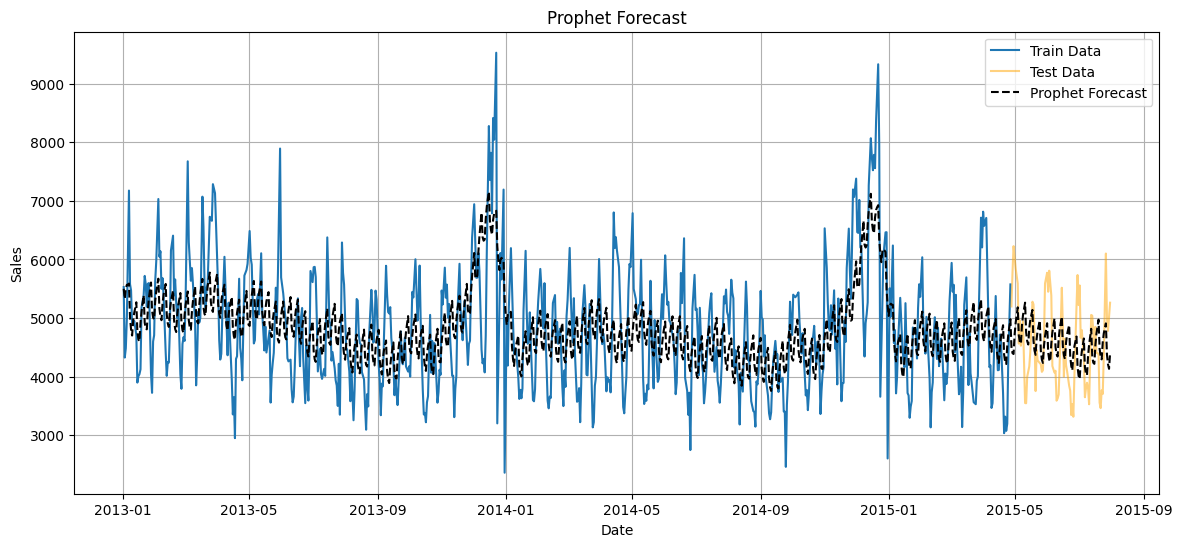

In [49]:
prophet_pred = forecast_prophet[forecast_prophet['ds'].isin(test_prophet['ds'])]['yhat'].values

prophet_metrics = evaluate_model(test_prophet['y'], prophet_pred, "Prophet Forecast")
plt.figure(figsize=(14,6))
plt.plot(train_prophet['ds'], train_prophet['y'], label='Train Data')
plt.plot(test_prophet['ds'], test_prophet['y'], label='Test Data', alpha=0.5, color='orange')
plt.plot(forecast_prophet['ds'], forecast_prophet['yhat'], label='Prophet Forecast', color='black', linestyle='--')
plt.title("Prophet Forecast")
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

In [50]:
def prepare_for_prophet_with_regressors(df, full_data):
    """
    Prepare Prophet-ready dataframe with one-hot encoded StateHoliday and other regressors.
    
    Parameters:
    - df: DataFrame with 'ds' (and 'y') columns
    - full_data: Rossmann training data with original features
    
    Returns:
    - df: with added 'promo', 'school_holiday', and one-hot 'state_holiday_*' columns
    """
    df = df.copy()
    df['ds'] = pd.to_datetime(df['ds'])
    full_data = full_data.copy()
    full_data['Date'] = pd.to_datetime(full_data['Date'])

    
    merged = pd.merge(df, full_data[['Date', 'Promo', 'SchoolHoliday', 'StateHoliday']],
                      how='left', left_on='ds', right_on='Date')

    
    merged['Promo'].fillna(0, inplace=True)
    merged['SchoolHoliday'].fillna(0, inplace=True)
    merged['StateHoliday'].fillna('0', inplace=True)

    # One-hot encode StateHoliday (drop='0')
    merged['StateHoliday'] = merged['StateHoliday'].astype(str)
    for holiday_type in ['a', 'b', 'c']:
        df[f'state_holiday_{holiday_type}'] = (merged['StateHoliday'] == holiday_type).astype(int)

    # Add other regressors
    df['promo'] = merged['Promo'].astype(int)
    df['school_holiday'] = merged['SchoolHoliday'].astype(int)

    return df



train_prophet_reg = prepare_for_prophet_with_regressors(train_prophet, train)
test_prophet_reg = prepare_for_prophet_with_regressors(test_prophet, test)

C:\Users\PCCV\AppData\Local\Temp\ipykernel_22812\3442776299.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged['Promo'].fillna(0, inplace=True)
C:\Users\PCCV\AppData\Local\Temp\ipykernel_22812\3442776299.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, whe

In [51]:
prophet_model2 = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)

prophet_model2.add_regressor('promo')
prophet_model2.add_regressor('school_holiday')
for holiday_type in ['state_holiday_a', 'state_holiday_b', 'state_holiday_c']:
    prophet_model2.add_regressor(holiday_type)



In [52]:
prophet_model2.fit(train_prophet_reg)


future_reg = prophet_model2.make_future_dataframe(periods=len(test_prophet_reg), freq='D')
full_reg = pd.concat([train_prophet_reg, test_prophet_reg], axis=0)
future_reg = future_reg.merge(full_reg.drop(columns=['y']), how='left', on='ds')

19:06:50 - cmdstanpy - INFO - Chain [1] start processing
19:06:50 - cmdstanpy - INFO - Chain [1] done processing


In [53]:
forecast_prophet_reg = prophet_model2.predict(future_reg)

# Get predictions for test period only
prophet_pred_reg = forecast_prophet_reg[forecast_prophet_reg['ds'].isin(test_prophet_reg['ds'])]['yhat'].values

----------------------------------------
Prophet with Regressors Forecast Results:
MSE: 573781.20
RMSE: 757.48
MAE: 650.59
RMSPE: 0.1739
----------------------------------------


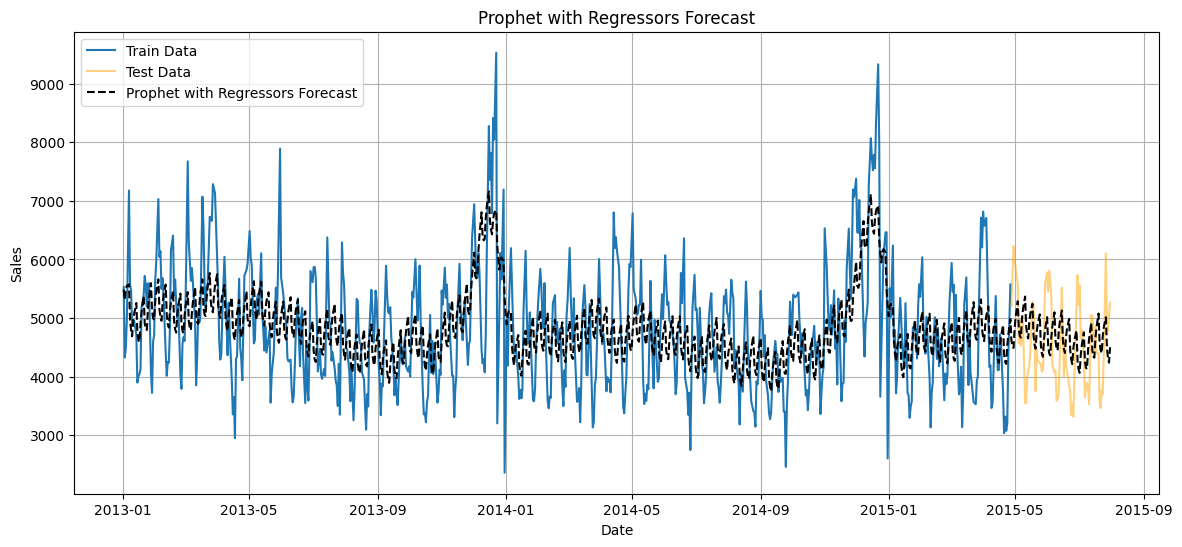

In [54]:
prophet_reg_metrics = evaluate_model(test_prophet_reg['y'], prophet_pred_reg, "Prophet with Regressors Forecast")

plt.figure(figsize=(14,6))
plt.plot(train_prophet_reg['ds'], train_prophet_reg['y'], label='Train Data')
plt.plot(test_prophet_reg['ds'], test_prophet_reg['y'], label='Test Data', alpha=0.5, color='orange')
plt.plot(forecast_prophet_reg['ds'], forecast_prophet_reg['yhat'], label='Prophet with Regressors Forecast', color='black', linestyle='--')
plt.title("Prophet with Regressors Forecast")
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

### `4- Machine Learning Models :`

--> Feature Engineering and extraction for ML and introduce Lags and Rolling ..

In [ ]:
def create_features_with_lags(df, lags=[1, 7], rolling_windows=[7, 14]):
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])

    
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Week'] = df['Date'].dt.isocalendar().week.astype(int)
    df['Day'] = df['Date'].dt.day
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype(int)

    # One-hot encode StateHoliday
    df['StateHoliday'] = df['StateHoliday'].astype(str)
    for cat in ['a', 'b', 'c']:
        df[f'StateHoliday_{cat}'] = (df['StateHoliday'] == cat).astype(int)

    
    df = df.sort_values(by=['Store', 'Date'])

    
    for lag in lags:
        df[f'Sales_lag_{lag}'] = df.groupby('Store')['Sales'].shift(lag)

    
    for window in rolling_windows:
        df[f'Sales_roll_mean_{window}'] = (df.groupby('Store')['Sales'].shift(1).rolling(window=window).mean().reset_index(0, drop=True))
        df[f'Sales_roll_std_{window}'] = (df.groupby('Store')['Sales'].shift(1).rolling(window=window).std().reset_index(0, drop=True))

    # Drop early rows based on the maximum lag/rolling window
    max_lag = max(max(lags, default=0), max(rolling_windows, default=0))
    df = df.groupby('Store').apply(lambda g: g.iloc[max_lag:]).reset_index(drop=True)

    return df


#### --> Preparing Train and Test datasets

In [80]:
test['Sales'] = np.nan
combined = pd.concat([train, test], sort=False)

combined_fe = create_features_with_lags(combined)

# Filter for a specific store and open days
store_data = combined_fe[(combined_fe['Store'] == store_id) & (combined_fe['Open'] == 1)]

# Split into train/test
train_ml = store_data[store_data['Sales'].notna()].copy()
test_ml = store_data[store_data['Sales'].isna()].copy()
test_ml.drop(columns=['Sales'], inplace=True)



print("Train rows:", train_ml.shape[0])
print("Test rows:", test_ml.shape[0])


C:\Users\PCCV\AppData\Local\Temp\ipykernel_22812\3540112011.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Store').apply(lambda g: g.iloc[max_lag:]).reset_index(drop=True)


Train rows: 770
Test rows: 41


In [ ]:
target_col = 'Sales'
drop_cols = [target_col , 'Date' , 'Customers' , 'Id' , 'StateHoliday' , 'StoreType' , 'Assortment' , 'PromoInterval']
features = [col for col in train_ml.columns if col not in drop_cols]
fill_cols = ['Sales_lag_1', 'Sales_lag_7', 'Sales_roll_mean_7', 'Sales_roll_std_7', 'Sales_roll_mean_14', 'Sales_roll_std_14']

for col in fill_cols:
    train_ml[col] = train_ml[col].fillna(train_ml[col].median())

for col in fill_cols:
    test_ml[col] = test_ml[col].fillna(train_ml[col].median()) 

In [ ]:
train_ml_sorted = train_ml.sort_values("Date")

split_date = train_ml_sorted["Date"].quantile(0.9)  

train_data = train_ml_sorted[train_ml_sorted["Date"] < split_date]
valid_data = train_ml_sorted[train_ml_sorted["Date"] >= split_date]

x_train = train_data[features]
y_train = train_data[target_col]
x_valid = valid_data[features]
y_valid = valid_data[target_col]


In [113]:
print(f"X_train shape: {x_train.shape}")
print(f"y_train shape:  {y_train.shape}")
print(f"X_valid shape: {x_valid.shape}")
print(f"y_valid shape:  {y_valid.shape}")

X_train shape: (693, 25)
y_train shape:  (693,)
X_valid shape: (77, 25)
y_valid shape:  (77,)


##### 1- Gradient Boosting : 

----------------------------------------
Gradient Boosting Regressor Results:
MSE: 135315.04
RMSE: 367.85
MAE: 284.68
RMSPE: 0.0833
----------------------------------------


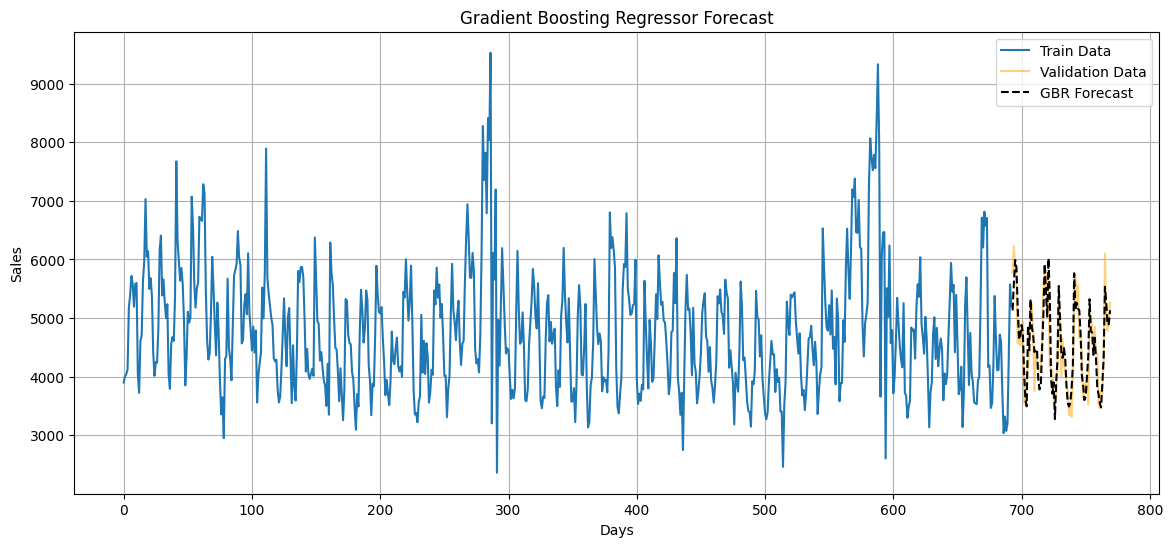

In [115]:
gbr = GradientBoostingRegressor(random_state=88)
gbr.fit(x_train, y_train)
gbr_pred = gbr.predict(x_valid)
gbr_metrics = evaluate_model(y_valid, gbr_pred, "Gradient Boosting Regressor")

plt.figure(figsize=(14,6))
plt.plot(range(len(train_data)), train_data['Sales'], label='Train Data')
plt.plot(range(len(train_data), len(train_data) + len(y_valid)), y_valid, label='Validation Data', alpha=0.5, color='orange')
plt.plot(range(len(train_data), len(train_data) + len(gbr_pred)), gbr_pred, label='GBR Forecast', color='black', linestyle='--')
plt.title("Gradient Boosting Regressor Forecast")
plt.xlabel('Days')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

##### 2- Xg Boost : 

----------------------------------------
XGBoost Regressor Results:
MSE: 137669.94
RMSE: 371.04
MAE: 303.54
RMSPE: 0.0830
----------------------------------------


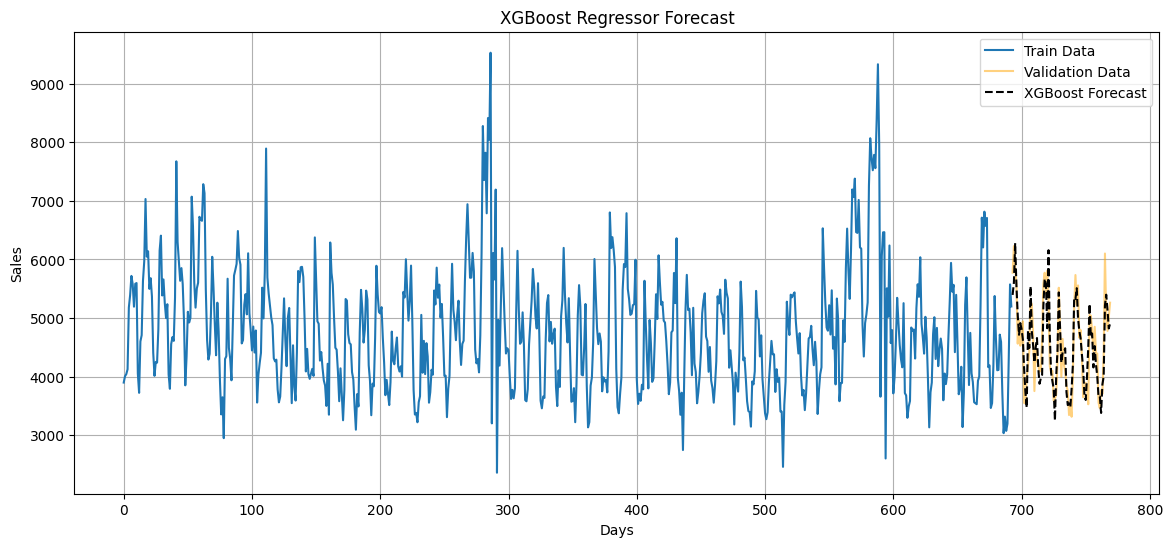

In [116]:
xgb = XGBRegressor(random_state=88)
xgb.fit(x_train, y_train)
xgb_pred = xgb.predict(x_valid)
xgb_metrics = evaluate_model(y_valid, xgb_pred, "XGBoost Regressor")

plt.figure(figsize=(14,6))
plt.plot(range(len(train_data)), train_data['Sales'], label='Train Data')
plt.plot(range(len(train_data), len(train_data) + len(y_valid)), y_valid, label='Validation Data', alpha=0.5, color='orange')
plt.plot(range(len(train_data), len(train_data) + len(xgb_pred)), xgb_pred, label='XGBoost Forecast', color='black', linestyle='--')
plt.title("XGBoost Regressor Forecast")
plt.xlabel('Days')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

##### 3- Cat Boosting : 

Learning rate set to 0.038638
0:	learn: 1019.7366566	total: 141ms	remaining: 2m 21s
1:	learn: 1003.0684835	total: 144ms	remaining: 1m 11s
2:	learn: 984.3409195	total: 146ms	remaining: 48.5s
3:	learn: 970.8424113	total: 148ms	remaining: 36.9s
4:	learn: 954.2351607	total: 150ms	remaining: 29.9s
5:	learn: 938.3142167	total: 152ms	remaining: 25.2s
6:	learn: 922.7603944	total: 154ms	remaining: 21.8s
7:	learn: 906.5598446	total: 155ms	remaining: 19.3s
8:	learn: 893.5591268	total: 158ms	remaining: 17.4s
9:	learn: 880.4688943	total: 160ms	remaining: 15.8s
10:	learn: 866.6301899	total: 162ms	remaining: 14.5s
11:	learn: 854.1158204	total: 163ms	remaining: 13.5s
12:	learn: 842.8086245	total: 165ms	remaining: 12.5s
13:	learn: 830.0869681	total: 167ms	remaining: 11.7s
14:	learn: 819.8793951	total: 169ms	remaining: 11.1s
15:	learn: 809.3326324	total: 170ms	remaining: 10.4s
16:	learn: 799.4978796	total: 171ms	remaining: 9.88s
17:	learn: 789.6919785	total: 172ms	remaining: 9.4s
18:	learn: 779.6414812	

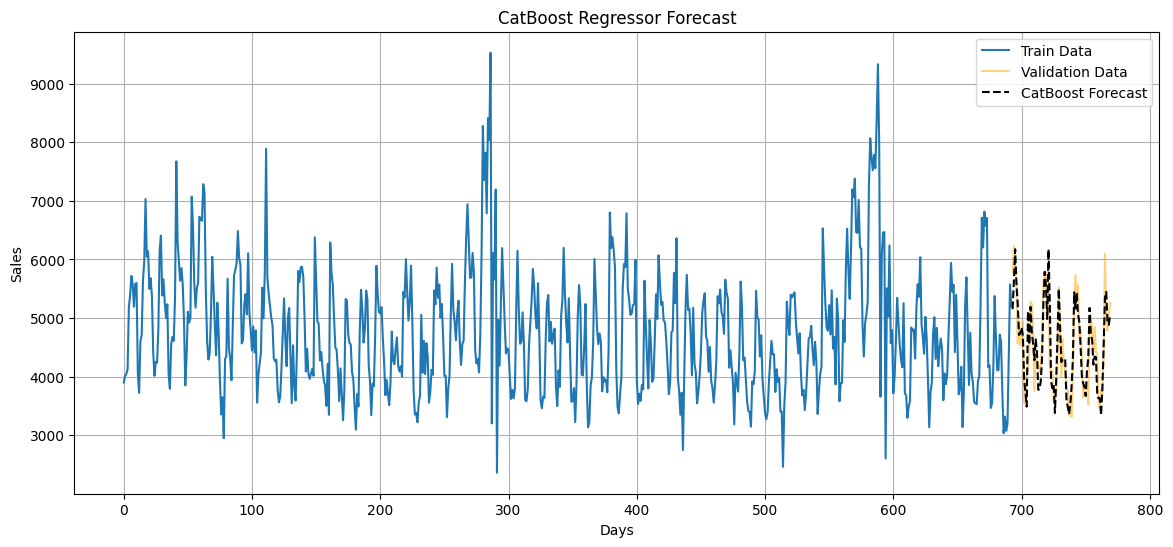

In [117]:
cbr = CatBoostRegressor(random_state=88)
cbr.fit(x_train, y_train)
cbr_pred = cbr.predict(x_valid)
cbr_metrics = evaluate_model(y_valid, cbr_pred, "CatBoost Regressor")

plt.figure(figsize=(14,6))
plt.plot(range(len(train_data)), train_data['Sales'], label='Train Data')
plt.plot(range(len(train_data), len(train_data) + len(y_valid)), y_valid, label='Validation Data', alpha=0.5, color='orange')
plt.plot(range(len(train_data), len(train_data) + len(cbr_pred)), cbr_pred, label='CatBoost Forecast', color='black', linestyle='--')
plt.title("CatBoost Regressor Forecast")
plt.xlabel('Days')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

In [125]:
# Compare all models scores together

model_scores = {
    "Naive Forecast": naive_metrics,
    "Moving Average": moving_avg_metrics,
    "SES": ses_metrics,
    "Holt's Linear": des_metrics,
    "Holt-Winters Additive": tes_metrics,
    "Holt-Winters Multiplicative": tes_metrics_mul,
    "ARIMA": arima_metrics,
    "SARIMAX": sarimax_metrics,
    "Prophet": prophet_metrics,
    "Prophet with Regressors": prophet_reg_metrics,
    "Gradient Boosting Regressor": gbr_metrics,
    "XGBoost Regressor": xgb_metrics,
    "CatBoost Regressor": cbr_metrics
}

scores_df = pd.DataFrame(model_scores).T
scores_df.columns = ['MSE', 'RMSE', 'MAE', 'RMSPE']
scores_df = scores_df.sort_values(by='RMSPE')
scores_df


,MSE,RMSE,MAE,RMSPE
XGBoost Regressor,1.376699e+05,371.039006,303.536945,0.082984
Gradient Boosting Regressor,1.353150e+05,367.851928,284.684401,0.083274
CatBoost Regressor,1.493572e+05,386.467623,310.405753,0.086507
Prophet,5.605575e+05,748.703869,632.911949,0.165331
Naive Forecast,5.996344e+05,774.360656,647.558246,0.170527
Moving Average,6.152523e+05,784.380232,657.019148,0.172213
Prophet with Regressors,5.737812e+05,757.483462,650.590510,0.173870
ARIMA,5.826873e+05,763.339600,653.138015,0.189603
SARIMAX,1.200229e+06,1095.549538,904.468863,0.266149
SES,1.528683e+06,1236.399394,1062.458670,0.317626


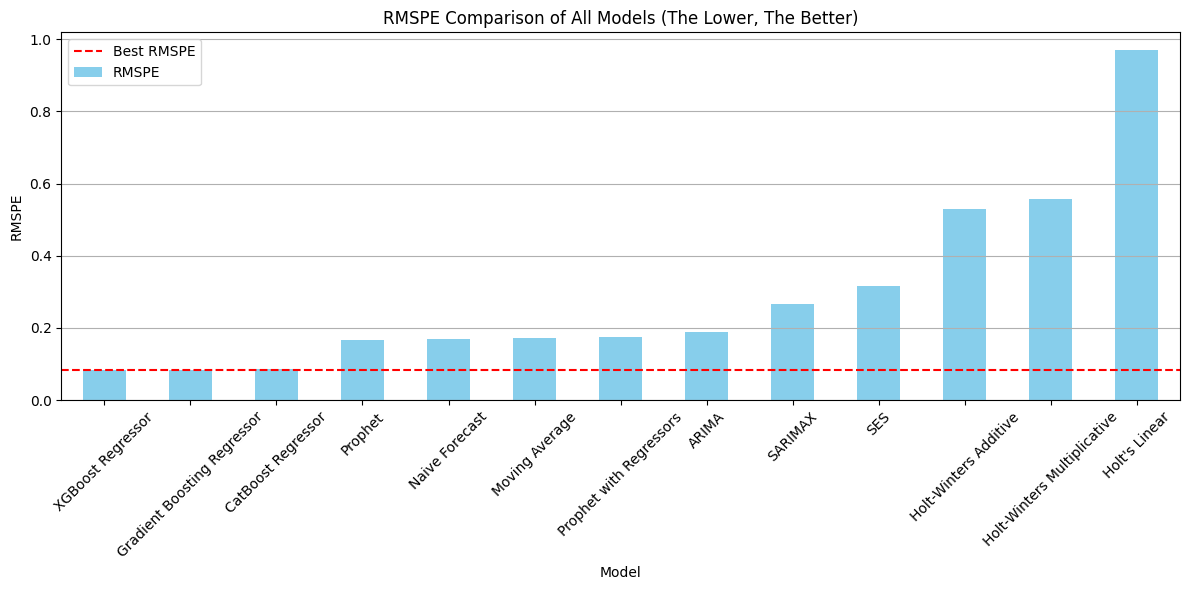

In [126]:
plt.figure(figsize=(12, 6))
scores_df['RMSPE'].plot(kind='bar', color='skyblue')
plt.title('RMSPE Comparison of All Models (The Lower, The Better)')
plt.axhline(y=scores_df['RMSPE'].min(), color='red', linestyle='--', label='Best RMSPE')
plt.ylabel('RMSPE')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.legend()
plt.show()

## 8. Summary and Conclusions

1. **Data Analysis:**
   - Strong weekly seasonality is evident in store sales
   - Promotions significantly boost sales
   - Sales are very low on Sundays and highest on Mondays
   - The sales are at their highest in December every year (due to christmas holiday and new's year eve )

2. **Model Performance:**
   - Simple Forecasting: Seasonal Naive model , Moving Average --> (They did well according to their simplicity). 
   - ETS Models: Simple Expontial Smoothing(SES) , Holt's Linear(DES) , Holt-Winters Additive and Multiplicative(TES) --> (Their performance was bad)
   - ARIMA Models: ARIMA , SARIMAX  --> (Their performance was moderate , The ARIMA is better)
   - Prophet: Basic PROPHET , PROPHET with Regrressor --> (There performance was good)
   - Machine Learning: Gradient Boosting , XGBoost , CatBoost performed very well by leveraging feature engineering  --> (Their perfromance was the Best)

3. **Best Model:**
   - Our best performing model was XGBoost Regressor
   - The model achieved a RMSE of 0.082